Iñigo Martin Melero

## Participante 9

Hacemos a lo que se refieren algunos papers. Nuestros datos de entrada son:

- Fisiológico: 2500000 elementos, medido milisegundo a milisegundo. 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10...
- Joystick: 40000 elementos, medido de 50 milisegundos en 50 milisegundos. 0, 50, 100, 150...

Cambiaremos los dataset de entrada para partir en igualdad de condiciones a los papers.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy import signal
from scipy import pi
from scipy.fftpack import rfft, rfftfreq

Leemos el csv del Joystick, y lo representamos.

In [2]:
df1=pd.read_csv('Bruto/sub_9_annotations.csv')
df1=df1.rename(columns={"jstime": "time"})
print(df1)

          time  valence  arousal  video
0            0      5.0      5.0     10
1           50      5.0      5.0     10
2          100      5.0      5.0     10
3          150      5.0      5.0     10
4          200      5.0      5.0     10
...        ...      ...      ...    ...
49027  2451350      5.0      5.0     12
49028  2451400      5.0      5.0     12
49029  2451450      5.0      5.0     12
49030  2451500      5.0      5.0     12
49031  2451550      5.0      5.0     12

[49032 rows x 4 columns]


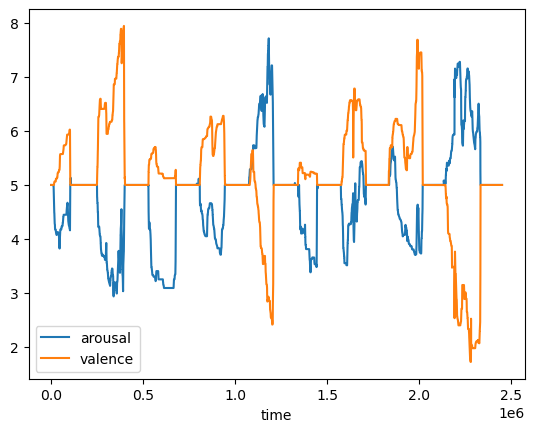

In [3]:
df1.plot(x="time", y=["arousal","valence"])
plt.show()

Leemos el csv de las variables Fisiológicas, y las representamos.

In [4]:
df2=pd.read_csv('Bruto/sub_9_physiological.csv')
df2=df2.rename(columns={"daqtime": "time"})
length_orig_df2=len(df2)
print(df2)

            time    ecg     bvp     gsr     rsp     skt  emg_zygo  emg_coru  \
0              0  1.106  36.690  33.710  35.964  22.494     9.303     8.644   
1              1  1.083  36.758  33.682  35.935  22.483     9.016     8.562   
2              2  1.060  36.825  33.654  35.906  22.473     8.728     8.480   
3              3  1.037  36.893  33.627  35.877  22.462     8.441     8.398   
4              4  1.046  36.980  33.584  35.905  22.466     8.560     8.356   
...          ...    ...     ...     ...     ...     ...       ...       ...   
2451579  2451579  0.577  36.845  31.880  36.932  22.245     5.686    10.696   
2451580  2451580  0.577  36.606  31.880  36.970  22.259     5.849    10.859   
2451581  2451581  0.583  36.728  31.938  36.922  22.241     5.688    10.698   
2451582  2451582  0.573  36.835  31.892  36.931  22.238     5.646    10.656   
2451583  2451583  0.564  36.663  31.974  36.931  22.241     5.686    10.696   

         emg_trap  video  
0          41.956     10

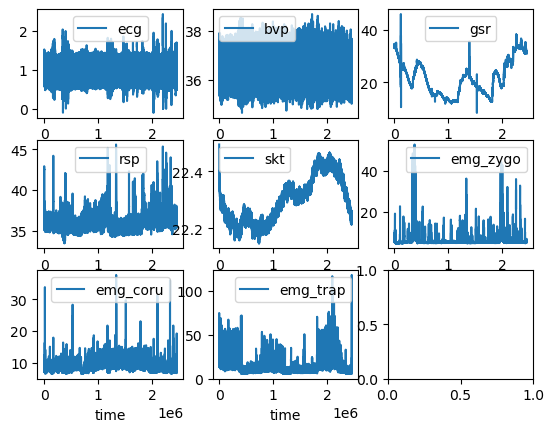

In [5]:
#define subplot layout
fig, axes = plt.subplots(nrows=3, ncols=3)

#add DataFrames to subplots
df2.plot(ax=axes[0,0],x="time",y="ecg")
df2.plot(ax=axes[0,1],x="time",y="bvp")
df2.plot(ax=axes[0,2],x="time",y="gsr")
df2.plot(ax=axes[1,0],x="time",y="rsp")
df2.plot(ax=axes[1,1],x="time",y="skt")
df2.plot(ax=axes[1,2],x="time",y="emg_zygo")
df2.plot(ax=axes[2,0],x="time",y="emg_coru")
df2.plot(ax=axes[2,1],x="time",y="emg_trap")
plt.show()

<AxesSubplot:xlabel='time'>

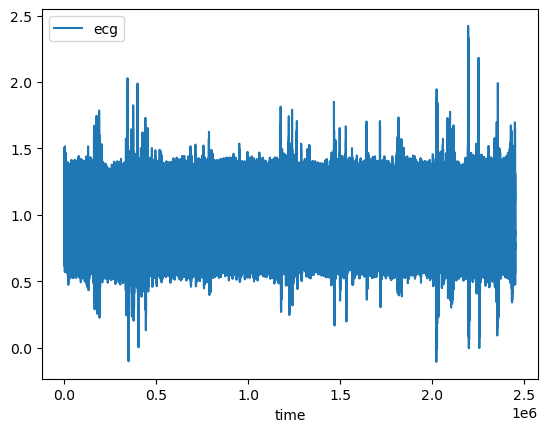

In [6]:
df2.plot(x="time",y="ecg")

<AxesSubplot:xlabel='time'>

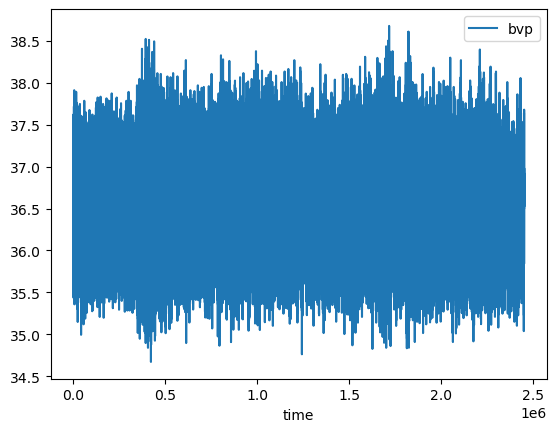

In [7]:
df2.plot(x="time",y="bvp")

<AxesSubplot:xlabel='time'>

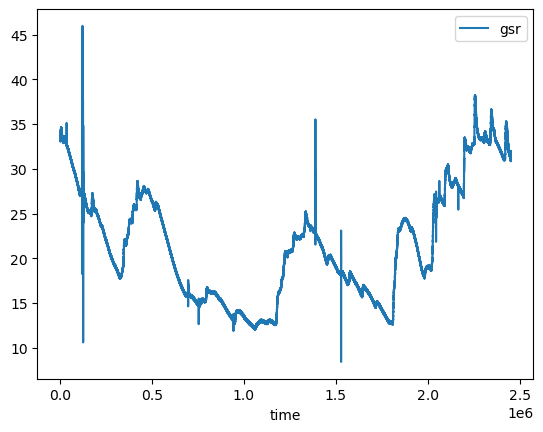

In [8]:
df2.plot(x="time",y="gsr")

<AxesSubplot:xlabel='time'>

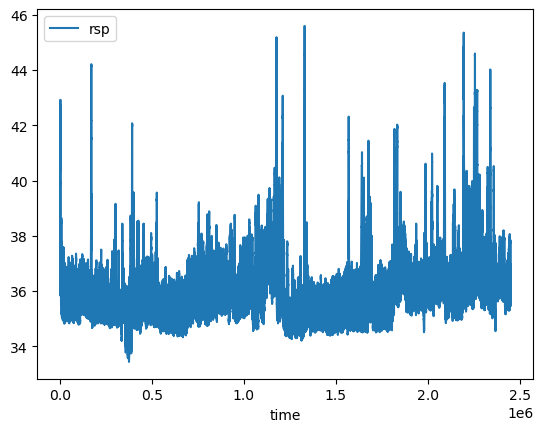

In [9]:
df2.plot(x="time",y="rsp")

<AxesSubplot:xlabel='time'>

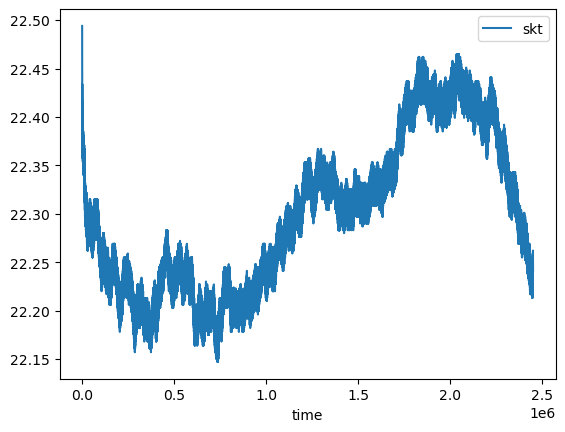

In [10]:
df2.plot(x="time",y="skt")


<AxesSubplot:xlabel='time'>

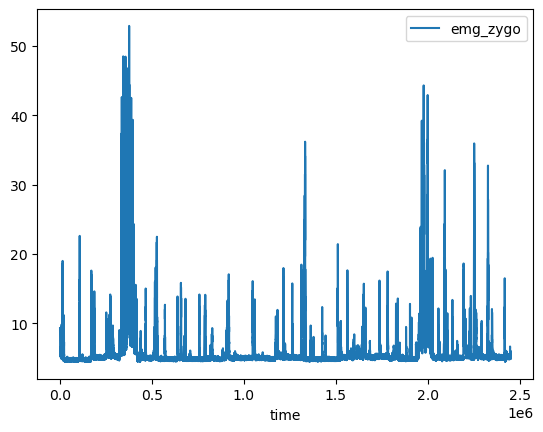

In [11]:
df2.plot(x="time",y="emg_zygo")


<AxesSubplot:xlabel='time'>

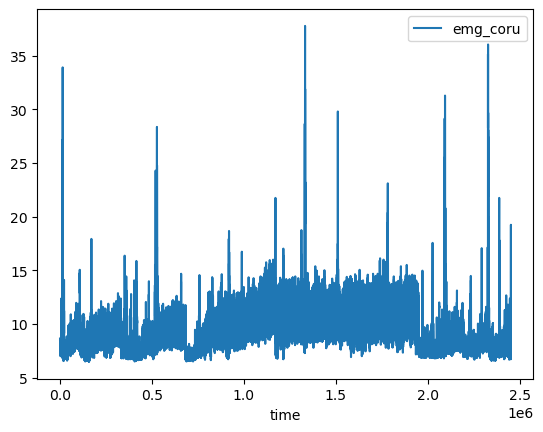

In [12]:
df2.plot(x="time",y="emg_coru")

<AxesSubplot:xlabel='time'>

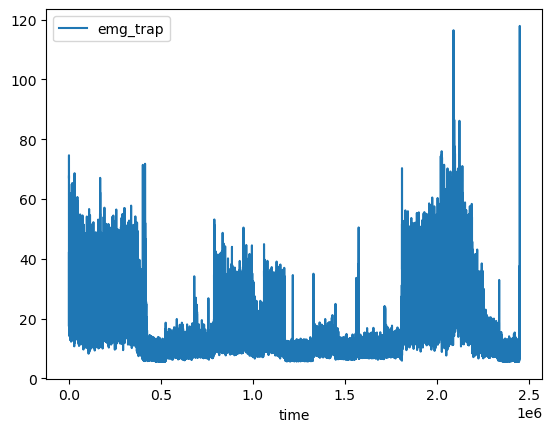

In [13]:
df2.plot(x="time",y="emg_trap")

El paper más completo que trata esto es CorrNet, donde se hace:

"Since the sampling rates of V-A and signals are 20 and 1000 Hz
respectively, we down-sampled all the signals to 50 Hz by decimation down-sampling. The EDA signals were
first filtered using a low pass filter with a 2 Hz cutoff frequency to remove noise.
For the BVP signal, we pre-processed it with a four-order butterworth bandpass filter with
cutoff frequencies [30, 200] Hz to eliminate the bursts. An elliptic band-pass filter
with cutoff frequencies [0.005, 0.1] was used to filter the ST signal. We followed the
standard filtering procedure widely used in previous works to pre-process the
physiological signals. Then the filtered signals are segmented into 2-second (sample size:
100 for CASE) instances."

O sea:

A) Se pasa filtro paso bajo 2 Hz a señales EDA (GSR).

B) Se pasa filtro de cuarto orden butterworth con frecuencias corte [30, 200] Hz a señal BVP.

C) Se utiliza un filtro de paso eliptico con frecuencias corte [0.005, 0.1] a señal ST (SKT).

D) Se normalizan las señales a 0 - 1, segun Min - Max.

E) Se busca la frecuencia en común de ambos a 50 Hz. Se hizo un estudio y fue la solución de compromiso.

F) Se utilizan ventanas de 2 segundos.

Lo vamos haciendo poco a poco.

    A) Se pasa filtro paso bajo 2 Hz a señales EDA (GSR).

<AxesSubplot:>

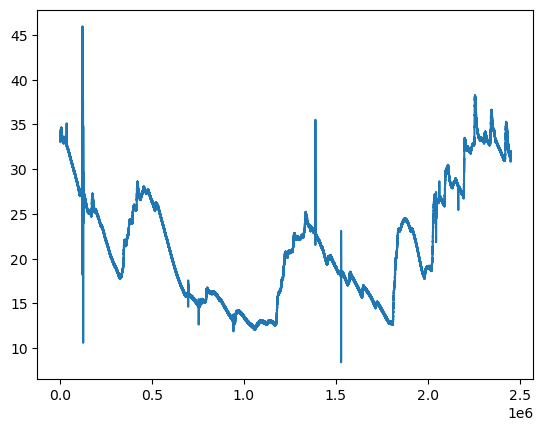

In [14]:
gsr_signal_notfiltered=df2['gsr']
gsr_signal_notfiltered.plot()

Representamos la senal en el dominio de la frecuencia. Vemos que hay frecuencias hasta el 500. Las querremos quitar todas menos las menores a 2 Hz. 

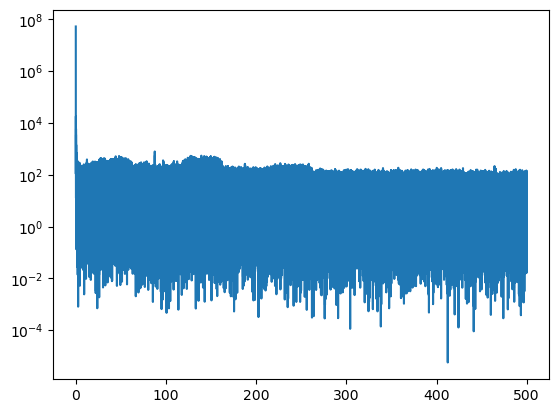

In [15]:
yf = rfft(gsr_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

In [16]:
lowpassfilter=signal.butter(N=10, Wn=2, btype='lp', fs=1000, output='sos')
gsr_filtered = signal.sosfilt(lowpassfilter, gsr_signal_notfiltered)

Comprobamos la senal filtrada. No deberia tener (o tener amplitud muy reducida) en las frecuencias a partir de los 2 Hz. Efectivamente vemos que se ha hecho lo mejor que se ha podido, y se han reducido notablemente las frecuencias mayores a 2 Hz. 

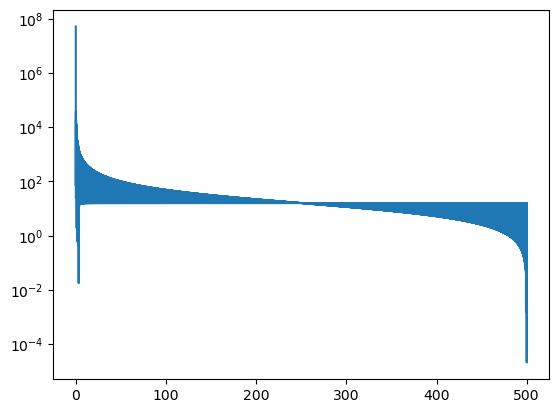

In [17]:
yf = rfft(gsr_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

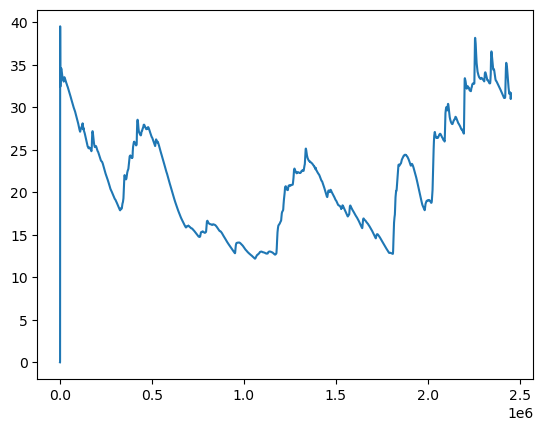

In [18]:
plt.plot(gsr_filtered)

In [19]:
gsr_signal_filtered = pd.DataFrame(gsr_filtered)
gsr_signal_filtered=gsr_signal_filtered.round(3)
gsr_signal_filtered=gsr_signal_filtered.rename(columns={0: "gsr"})
gsr_signal_filtered

gsr
0         0.000
1         0.000
2         0.000
3         0.000
4         0.000
...         ...
2451579  31.616
2451580  31.617
2451581  31.618
2451582  31.618
2451583  31.619

[2451584 rows x 1 columns]

B) Se pasa filtro de cuarto orden butterworth con frecuencias corte [30, 200] Hz a señal BVP.

<AxesSubplot:>

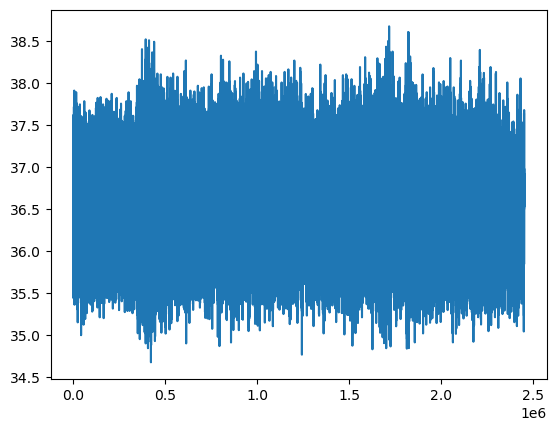

In [20]:
bvp_signal_notfiltered=df2['bvp']
bvp_signal_notfiltered.plot()

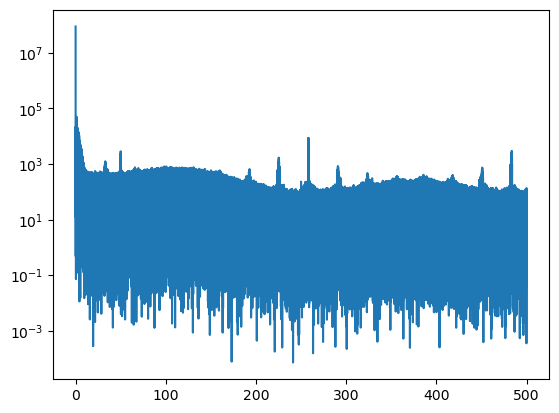

In [21]:
yf = rfft(bvp_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

Configuramos el filtro Butter con frecuencias de corte de 30 a 200 Hz, de cuarto orden. Es un filtro paso banda.

In [22]:
butterfilter=signal.butter(N=4, Wn=[30,200], btype='bandpass', fs=1000, output='sos')
bvp_filtered = signal.sosfilt(butterfilter, bvp_signal_notfiltered)

Comprobamos la senal filtrada. No deberia tener (o tener amplitud muy reducida) en las frecuencias menores de 30 Hz y mayores a 200 Hz. Efectivamente vemos que se ha hecho lo mejor que se ha podido, y se han reducido notablemente esas frecuencias.

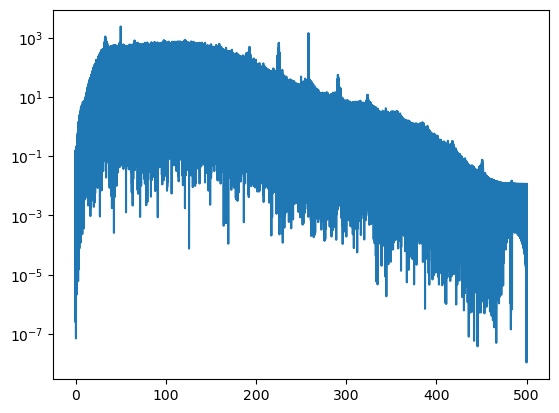

In [23]:
yf = rfft(bvp_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

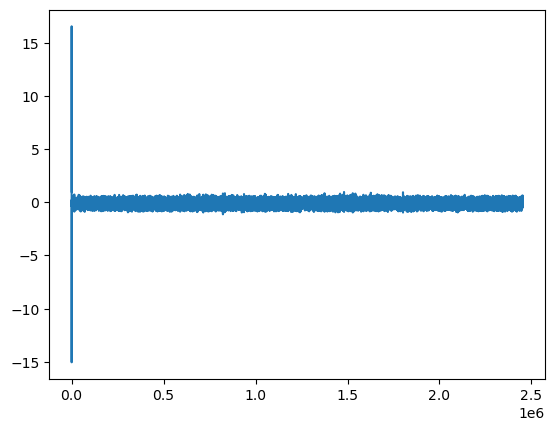

In [24]:
plt.plot(bvp_filtered)

Vemos que el paso banda está centrado en el 0, por lo que lo offseteamos a arriba. Este problema le pasa a más gente, así que no pasa nada. Luego, como normalizaremos los datos, este efecto se eliminará lo offseteemos lo que lo offseteemos.

In [25]:
bvp_signal_filtered = pd.DataFrame(bvp_filtered)
bvp_signal_filtered=bvp_signal_filtered.round(3)
bvp_signal_filtered=bvp_signal_filtered.rename(columns={0: "bvp"})
bvp_signal_filtered=bvp_signal_filtered.add(37)
bvp_signal_filtered

bvp
0        38.019
1        42.689
2        50.394
3        53.583
4        46.323
...         ...
2451579  36.882
2451580  36.930
2451581  37.007
2451582  37.017
2451583  36.988

[2451584 rows x 1 columns]

    C) Se utiliza un filtro de paso eliptico con frecuencias corte [0.005, 0.1] a señal ST (SKT).

<AxesSubplot:>

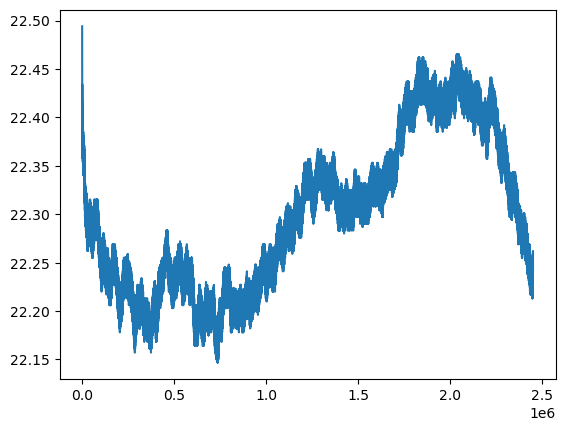

In [26]:
skt_signal_notfiltered=df2['skt']
skt_signal_notfiltered.plot()

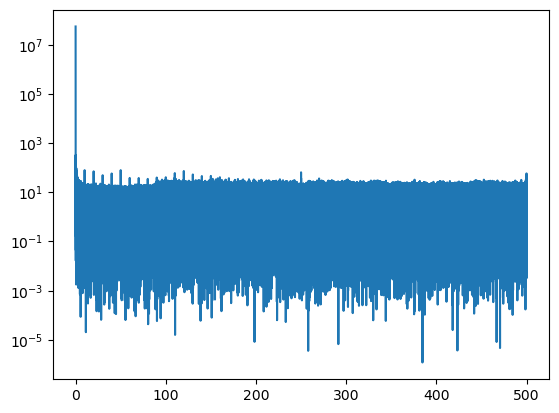

In [27]:
yf = rfft(skt_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

Configuramos nuestro filtro eliptico con frecuencias corte [0.005, 0.1] a señal skt.

In [28]:
ellipticfilter=signal.ellip(N=4,rp=1, rs=1, Wn=[0.005,0.1], btype='bandpass', fs=1000, output='sos')
skt_filtered = signal.sosfilt(ellipticfilter, skt_signal_notfiltered)

Comprobamos la senal filtrada. Algo ha filtrado.

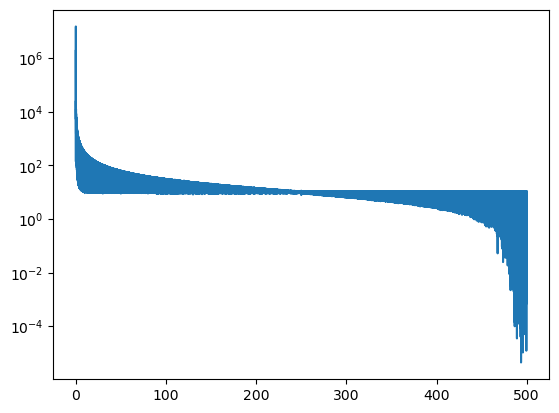

In [29]:
yf = rfft(skt_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

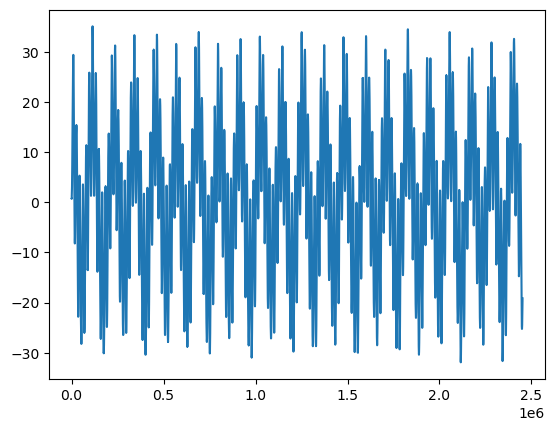

In [30]:
plt.plot(skt_filtered)

Vemos que el paso banda está centrado en el 0, por lo que lo offseteamos a arriba. Este problema le pasa a más gente, así que no pasa nada. Luego, como normalizaremos los datos, este efecto se eliminará lo offseteemos lo que lo offseteemos.

In [31]:
skt_signal_filtered = pd.DataFrame(skt_filtered)
skt_signal_filtered=skt_signal_filtered.round(3)
skt_signal_filtered=skt_signal_filtered.rename(columns={0: "skt"})
skt_signal_filtered=skt_signal_filtered.add(40)
skt_signal_filtered

skt
0        40.721
1        40.720
2        40.720
3        40.720
4        40.720
...         ...
2451579  20.822
2451580  20.826
2451581  20.829
2451582  20.833
2451583  20.837

[2451584 rows x 1 columns]

D) Se normalizan las senales.

Antes de normalizarlas, vamos a borrar las primeras 5000, ya que por los filtrados los principios de las senales son un poco raros. Borramos las columnas que acabamos de tunear del dataframe con todo.

In [32]:
df2=df2.drop(columns=["skt","bvp","gsr"])
df2

time    ecg     rsp  emg_zygo  emg_coru  emg_trap  video
0              0  1.106  35.964     9.303     8.644    41.956     10
1              1  1.083  35.935     9.016     8.562    41.299     10
2              2  1.060  35.906     8.728     8.480    40.642     10
3              3  1.037  35.877     8.441     8.398    39.985     10
4              4  1.046  35.905     8.560     8.356    39.368     10
...          ...    ...     ...       ...       ...       ...    ...
2451579  2451579  0.577  36.932     5.686    10.696    19.153     12
2451580  2451580  0.577  36.970     5.849    10.859    20.011     12
2451581  2451581  0.583  36.922     5.688    10.698    20.995     12
2451582  2451582  0.573  36.931     5.646    10.656    21.981     12
2451583  2451583  0.564  36.931     5.686    10.696    23.007     12

[2451584 rows x 7 columns]

In [33]:
df2=pd.concat([df2, bvp_signal_filtered, gsr_signal_filtered,skt_signal_filtered], axis=1)
df2

time    ecg     rsp  emg_zygo  emg_coru  emg_trap  video     bvp  \
0              0  1.106  35.964     9.303     8.644    41.956     10  38.019   
1              1  1.083  35.935     9.016     8.562    41.299     10  42.689   
2              2  1.060  35.906     8.728     8.480    40.642     10  50.394   
3              3  1.037  35.877     8.441     8.398    39.985     10  53.583   
4              4  1.046  35.905     8.560     8.356    39.368     10  46.323   
...          ...    ...     ...       ...       ...       ...    ...     ...   
2451579  2451579  0.577  36.932     5.686    10.696    19.153     12  36.882   
2451580  2451580  0.577  36.970     5.849    10.859    20.011     12  36.930   
2451581  2451581  0.583  36.922     5.688    10.698    20.995     12  37.007   
2451582  2451582  0.573  36.931     5.646    10.656    21.981     12  37.017   
2451583  2451583  0.564  36.931     5.686    10.696    23.007     12  36.988   

            gsr     skt  
0         0.000  40.721  
1         0.000  40.720  
2         0.000  40.720  
3         0.000  40.720  
4         0.000  40.720  
...         ...     ...  
2451579  31.616  20.822  
2451580  31.617  20.826  
2451581  31.618  20.829  
2451582  31.618  20.833  
2451583  31.619  20.837  

[2451584 rows x 10 columns]

Tras aclarar esto, ya pasamos a normalizar. Antes, quitamos los videos que van al train, para que se normalicen solo los datos que van a ser entrenados realmente (sin los videos de BlueScreen, EndVid y StartVid).

In [34]:
df2 = df2[df2.video != 10]
df2 = df2[df2.video != 11]
df2 = df2[df2.video != 12]
scaler = MinMaxScaler()
scaler.fit(df2)
normalized = pd.DataFrame(scaler.transform(df2), index=df2.index, columns=df2.columns)
df2_normalized = pd.DataFrame(normalized, columns=df2.columns)
df2_normalized=df2_normalized.drop(columns=["video","time"])
numvideo_bien = df2["video"] 
tiempo_bien=df2["time"] 
df2_normalized=df2_normalized.join(numvideo_bien)
df2_normalized=df2_normalized.join(tiempo_bien)
df2=df2_normalized[["time","ecg","bvp","gsr","skt","rsp","emg_zygo","emg_coru","emg_trap","video"]]
df2

time       ecg       bvp       gsr       skt       rsp  emg_zygo  \
221501    221501  0.334125  0.523856  0.445382  0.792719  0.125853  0.009307   
221502    221502  0.339272  0.536153  0.445382  0.792641  0.128979  0.012651   
221503    221503  0.344418  0.556813  0.445382  0.792578  0.130542  0.015210   
221504    221504  0.338084  0.552878  0.445382  0.792484  0.126676  0.010195   
221505    221505  0.342043  0.540580  0.445382  0.792406  0.128157  0.010979   
...          ...       ...       ...       ...       ...       ...       ...   
2331579  2331579  0.378464  0.627644  0.799592  0.353174  0.276302  0.010154   
2331580  2331580  0.375693  0.610920  0.799592  0.353253  0.278687  0.010979   
2331581  2331581  0.378464  0.611904  0.799592  0.353347  0.277124  0.010979   
2331582  2331582  0.376880  0.608952  0.799592  0.353425  0.280250  0.011825   
2331583  2331583  0.375693  0.573045  0.799592  0.353503  0.275561  0.008482   

         emg_coru  emg_trap  video  
221501   0.071252  0.565554      2  
221502   0.072537  0.570629      2  
221503   0.072569  0.567572      2  
221504   0.068650  0.558216      2  
221505   0.068618  0.552529      2  
...           ...       ...    ...  
2331579  0.079122  0.075949      7  
2331580  0.079154  0.074069      7  
2331581  0.077837  0.072189      7  
2331582  0.083074  0.072800      7  
2331583  0.076585  0.068458      7  

[1270083 rows x 10 columns]

    E) Frecuencia común 50 Hz

Para la frecuencia comun a ambos, ello implica tener lecturas cada 1/50 = 20 ms. Para las senales fisiologicas lo tenemos, pero para las annotations no, por lo que hay que resample. Primero resampleamos a que nos saque todos los valores por milisegundo de annotations, y luego downsampleamos para quedarnos solo con los que sean menores a 20 ms. 

In [35]:
n_samples=length_orig_df2
df1_clean=df1.drop(columns=['time', 'video'])
array1_resampled=signal.resample(df1_clean, n_samples)
df1_resampled=pd.DataFrame(array1_resampled,columns=["valence","arousal"])
df1_resampled=df1_resampled.round(3)
print(df1_resampled)

         valence  arousal
0            5.0      5.0
1            5.0      5.0
2            5.0      5.0
3            5.0      5.0
4            5.0      5.0
...          ...      ...
2451579      5.0      5.0
2451580      5.0      5.0
2451581      5.0      5.0
2451582      5.0      5.0
2451583      5.0      5.0

[2451584 rows x 2 columns]


Unimos los csv, con columna intersección en "time". Borramos los instantes de tiempo X e Y porque en realidad no son necesarios. Reordenamos las columnas.

In [36]:
df3=pd.merge(df1_resampled, df2, left_index=True, right_index=True)

columnsTitles = ['time', 'ecg', 'bvp','gsr','rsp','skt','emg_zygo','emg_coru','emg_trap','valence','arousal','video']
df3 = df3.reindex(columns=columnsTitles)

print(df3)

            time       ecg       bvp       gsr       rsp       skt  emg_zygo  \
221501    221501  0.334125  0.523856  0.445382  0.125853  0.792719  0.009307   
221502    221502  0.339272  0.536153  0.445382  0.128979  0.792641  0.012651   
221503    221503  0.344418  0.556813  0.445382  0.130542  0.792578  0.015210   
221504    221504  0.338084  0.552878  0.445382  0.126676  0.792484  0.010195   
221505    221505  0.342043  0.540580  0.445382  0.128157  0.792406  0.010979   
...          ...       ...       ...       ...       ...       ...       ...   
2331579  2331579  0.378464  0.627644  0.799592  0.276302  0.353174  0.010154   
2331580  2331580  0.375693  0.610920  0.799592  0.278687  0.353253  0.010979   
2331581  2331581  0.378464  0.611904  0.799592  0.277124  0.353347  0.010979   
2331582  2331582  0.376880  0.608952  0.799592  0.280250  0.353425  0.011825   
2331583  2331583  0.375693  0.573045  0.799592  0.275561  0.353503  0.008482   

         emg_coru  emg_trap  valence  a

Downsampleamos a 20 ms y eliminamos la columna tiempo. 

In [37]:
df3 = df3.drop(df3[df3.time%20 != 0].index)
df3 = df3.drop(columns=['time'])
print(df3)

              ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
221520   0.336896  0.541072  0.445382  0.125771  0.791263  0.010958  0.090976   
221540   0.336896  0.608460  0.445343  0.125031  0.789728  0.010133  0.069935   
221560   0.463975  0.566650  0.445305  0.125031  0.788193  0.011846  0.051495   
221580   0.538401  0.578947  0.445266  0.123386  0.786642  0.010979  0.047480   
221600   0.300079  0.630595  0.445228  0.121083  0.785091  0.009307  0.046195   
...           ...       ...       ...       ...       ...       ...       ...   
2331500  0.358670  0.533202  0.799746  0.278687  0.346595  0.008441  0.073950   
2331520  0.357482  0.585834  0.799707  0.280332  0.348256  0.011846  0.068618   
2331540  0.367775  0.515986  0.799669  0.282636  0.349932  0.013497  0.058017   
2331560  0.370546  0.539597  0.799630  0.278687  0.351592  0.009307  0.063317   
2331580  0.375693  0.610920  0.799592  0.278687  0.353253  0.010979  0.079154   

         emg_trap  valence 

Creamos la ventana de n = 2 segundos. Una ventana de datos simplemente será concatenar los datos dentro de grupos de 2 segundos, haciendo la media de valencia y de arousal de todos ellos. 

Como la frecuencia de muestreo son 20 ms, cada ventana de 2 segundos tendrá en total 100 observaciones. Después, esto lo "flattenaremos" para que el modelo ML en R pueda tragarlo.  

En primer lugar, como las ventanas son de 2 segundos, eliminamos un número de datos para que nos den las ventanas justas. Tendríamos varios criterios:

- A) Ver en el completo de los datos las entradas que tenemos múltiplos de 100 (ventanas de 2 s), y eliminar del múltiplo más alto hasta el final.

- B) Algo más fino quizá sería hacer lo mismo pero video a video. 

Por simplicidad y ver lo que sale hacemos A). Comenzamos creando un nuevo indice desde 0 del Dataframe que tenemos y borramos el valor del video. 

In [38]:
df3 = df3.drop(columns=['video'])
df3 = df3.reset_index()
df3 = df3.drop(columns=['index'])
df3

ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
0      0.336896  0.541072  0.445382  0.125771  0.791263  0.010958  0.090976   
1      0.336896  0.608460  0.445343  0.125031  0.789728  0.010133  0.069935   
2      0.463975  0.566650  0.445305  0.125031  0.788193  0.011846  0.051495   
3      0.538401  0.578947  0.445266  0.123386  0.786642  0.010979  0.047480   
4      0.300079  0.630595  0.445228  0.121083  0.785091  0.009307  0.046195   
...         ...       ...       ...       ...       ...       ...       ...   
63499  0.358670  0.533202  0.799746  0.278687  0.346595  0.008441  0.073950   
63500  0.357482  0.585834  0.799707  0.280332  0.348256  0.011846  0.068618   
63501  0.367775  0.515986  0.799669  0.282636  0.349932  0.013497  0.058017   
63502  0.370546  0.539597  0.799630  0.278687  0.351592  0.009307  0.063317   
63503  0.375693  0.610920  0.799592  0.278687  0.353253  0.010979  0.079154   

       emg_trap  valence  arousal  
0      0.501773    5.000    5.000  
1      0.256818    5.000    5.000  
2      0.181465    5.000    5.000  
3      0.237357    5.000    5.000  
4      0.312099    5.000    5.000  
...         ...      ...      ...  
63499  0.055250    2.361    5.948  
63500  0.044548    2.363    5.945  
63501  0.084021    2.366    5.941  
63502  0.101067    2.369    5.938  
63503  0.074069    2.372    5.935  

[63504 rows x 10 columns]

Como tenemos 63504 filas, necesitamos borrar solo las ultimas 4.

In [39]:
df3=df3.drop([63503, 63502, 63501, 63500])
df3

ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
0      0.336896  0.541072  0.445382  0.125771  0.791263  0.010958  0.090976   
1      0.336896  0.608460  0.445343  0.125031  0.789728  0.010133  0.069935   
2      0.463975  0.566650  0.445305  0.125031  0.788193  0.011846  0.051495   
3      0.538401  0.578947  0.445266  0.123386  0.786642  0.010979  0.047480   
4      0.300079  0.630595  0.445228  0.121083  0.785091  0.009307  0.046195   
...         ...       ...       ...       ...       ...       ...       ...   
63495  0.353523  0.559764  0.799861  0.273094  0.339907  0.009287  0.065951   
63496  0.347189  0.354648  0.799823  0.281813  0.341583  0.009287  0.081757   
63497  0.348377  0.571077  0.799784  0.275479  0.343259  0.008441  0.080472   
63498  0.353523  0.607969  0.799784  0.277124  0.344919  0.007595  0.073918   
63499  0.358670  0.533202  0.799746  0.278687  0.346595  0.008441  0.073950   

       emg_trap  valence  arousal  
0      0.501773    5.000    5.000  
1      0.256818    5.000    5.000  
2      0.181465    5.000    5.000  
3      0.237357    5.000    5.000  
4      0.312099    5.000    5.000  
...         ...      ...      ...  
63495  0.111707    2.352    5.958  
63496  0.182688    2.356    5.957  
63497  0.123647    2.358    5.954  
63498  0.090427    2.360    5.952  
63499  0.055250    2.361    5.948  

[63500 rows x 10 columns]

Y ahora si, con split dividimos el Dataset en 635 entradas de 100 datos cada una. 

In [40]:
df3_split_2s = np.array_split(df3, len(df3)/25)
df3_split_2s

[         ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
 0   0.336896  0.541072  0.445382  0.125771  0.791263  0.010958  0.090976   
 1   0.336896  0.608460  0.445343  0.125031  0.789728  0.010133  0.069935   
 2   0.463975  0.566650  0.445305  0.125031  0.788193  0.011846  0.051495   
 3   0.538401  0.578947  0.445266  0.123386  0.786642  0.010979  0.047480   
 4   0.300079  0.630595  0.445228  0.121083  0.785091  0.009307  0.046195   
 5   0.361441  0.590753  0.445228  0.124208  0.783556  0.014384  0.061968   
 6   0.357482  0.551894  0.445189  0.123468  0.782005  0.013538  0.077837   
 7   0.365400  0.356616  0.445151  0.126594  0.780455  0.014384  0.073886   
 8   0.367775  0.547467  0.445151  0.124208  0.778904  0.012671  0.069935   
 9   0.374505  0.602066  0.445112  0.121823  0.777337  0.011846  0.069967   
 10  0.378464  0.576488  0.445074  0.121823  0.775787  0.012671  0.083074   
 11  0.378464  0.540089  0.445035  0.121083  0.774236  0.010979  0.077837   

Ahora, realizaremos el Flatteneado. Las matrices las haremos una linea continua: pasamos de tener 100 observaciones de 8 variables a tener 1 observacion de 800 variables. 
Creamos el Dataframe que nos contenga todo, que tendrá 800 variables + Valence + Arousal (802 en total). Le ponemos nombre a las columnas del Dataframe solamente porque no se puede crear un Dataframe sin columnas, sino solo nos importaría llamar a la de Valence y Arousal.  

In [41]:
list_array = list(np.arange(1,201))
list_array.append("valence")
list_array.append("arousal")
df4 = pd.DataFrame(columns=list_array)
df4

Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, ...]
Index: []

[0 rows x 202 columns]

Y ahora hago el proceso de hacer el flatenning, y obtener el nuevo Dataframe con la ventana aplicada que exportaremos. Lo hacemos con un for para que repase todas las agrupaciones de 8 x 100 datos. De cada ventana calculamos (según papers) la valence y arousal promedios, y eso lo anadiremos en las ultimas dos columnas). 

In [42]:
for entrada in df3_split_2s:
    ave_valence=entrada['valence'].mean()
    ave_arousal=entrada['arousal'].mean()
    entrada=entrada.drop(columns=['valence','arousal'])
    a=entrada.to_numpy().flatten()
    a=np.append(a, ave_valence)
    a=np.append(a, ave_arousal)
    df4.loc[len(df4)] = a

In [43]:
df4

1         2         3         4         5         6         7  \
0     0.336896  0.541072  0.445382  0.125771  0.791263  0.010958  0.090976   
1     0.362629  0.538121  0.444534  0.123386  0.752291  0.014343  0.072537   
2     0.355107  0.568618  0.444034  0.156864  0.713053  0.011000  0.062032   
3     0.332937  0.521889  0.443302  0.242083  0.674927  0.010979  0.061968   
4     0.375693  0.459420  0.442762  0.301719  0.638994  0.009287  0.110797   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.370546  0.523856  0.802211  0.217406  0.161730  0.051696  0.179511   
2536  0.331354  0.582882  0.801441  0.179896  0.191805  0.024558  0.069903   
2537  0.401821  0.478111  0.800824  0.161635  0.226704  0.006748  0.077837   
2538  0.330166  0.591736  0.800632  0.167229  0.265378  0.007595  0.046195   
2539  0.348377  0.607969  0.800208  0.215020  0.306418  0.008399  0.065951   

             8         9        10  ...       193       194       195  \
0     0.501773  0.336896  0.608460  ...  0.353523  0.525332  0.444573   
1     0.396242  0.353523  0.607477  ...  0.357482  0.597147  0.444034   
2     0.227986  0.363816  0.560256  ...  0.330166  0.575996  0.443340   
3     0.165765  0.344418  0.525824  ...  0.382423  0.527300  0.442801   
4     0.177521  0.362629  0.472700  ...  0.349565  0.563699  0.442262   
...        ...       ...       ...  ...       ...       ...       ...   
2535  0.064056  0.383610  0.590261  ...  0.341647  0.589277  0.801479   
2536  0.114811  0.331354  0.581899  ...  0.400238  0.572061  0.800863   
2537  0.040803  0.400238  0.546975  ...  0.326207  0.532710  0.800670   
2538  0.084113  0.325020  0.549434  ...  0.349565  0.522873  0.800247   
2539  0.099813  0.361441  0.586326  ...  0.358670  0.533202  0.799746   

           196       197       198       199       200  valence  arousal  
0     0.119437  0.753857  0.011000  0.073854  0.301856  5.00000  5.00000  
1     0.162376  0.714619  0.012671  0.077805  0.317618  5.00000  5.00000  
2     0.239615  0.676415  0.010958  0.068553  0.319590  5.00000  5.00000  
3     0.298593  0.640372  0.006769  0.075203  0.287669  5.00000  5.00000  
4     0.327219  0.607415  0.010958  0.059334  0.535299  5.00000  5.00000  
...        ...       ...       ...       ...       ...      ...      ...  
2535  0.179156  0.190505  0.027097  0.085772  0.028221  2.22756  6.01412  
2536  0.164021  0.225231  0.008420  0.096277  0.068397  2.28584  5.99508  
2537  0.163280  0.263765  0.005902  0.031675  0.053278  2.29788  5.98860  
2538  0.210249  0.304741  0.004231  0.071284  0.128050  2.31444  5.97948  
2539  0.278687  0.346595  0.008441  0.073950  0.055250  2.33836  5.96712  

[2540 rows x 202 columns]

Para esta iteracion, analizamos los datos segun CorrNet. CorrNet propone 3 clasificaciones diferentes:
- Clasificación en 2 clases:
    
    Modelo ML A: Clasificamos Arousal en High y Low.
    
    Modelo ML B: Clasificamos Valence en High y Low. 


- Clasificación en 3 clases:
    
    Modelo ML C: Clasificamos Arousal en High, Neutral y Low.
   
    Modelo ML D: Clasificamos Valence en High, Neutral y Low.
    
    
- Clasificación en 4 clases:
    
    Modelo ML E: Clasificamos Valence y Arousal en los cuatro cuadrantes: High High, High Low, Low Low y Low High. 
   
   
Para cada uno, realizamos un dataframe diferente. 

- Modelo A. Clasificamos Arousal en High y Low. High --> 2 y Low --> 1

In [44]:
df4_A = df4.drop(columns=['valence'])
df4_A=df4_A.rename(columns={"arousal": "auxiliar"})
df4_A.loc[df4_A['auxiliar'] < 5, 'arousal'] = 1
df4_A.loc[df4_A['auxiliar'] >= 5, 'arousal'] = 2
df4_A = df4_A.drop(columns=['auxiliar'])
print(df4_A)

             1         2         3         4         5         6         7  \
0     0.336896  0.541072  0.445382  0.125771  0.791263  0.010958  0.090976   
1     0.362629  0.538121  0.444534  0.123386  0.752291  0.014343  0.072537   
2     0.355107  0.568618  0.444034  0.156864  0.713053  0.011000  0.062032   
3     0.332937  0.521889  0.443302  0.242083  0.674927  0.010979  0.061968   
4     0.375693  0.459420  0.442762  0.301719  0.638994  0.009287  0.110797   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.370546  0.523856  0.802211  0.217406  0.161730  0.051696  0.179511   
2536  0.331354  0.582882  0.801441  0.179896  0.191805  0.024558  0.069903   
2537  0.401821  0.478111  0.800824  0.161635  0.226704  0.006748  0.077837   
2538  0.330166  0.591736  0.800632  0.167229  0.265378  0.007595  0.046195   
2539  0.348377  0.607969  0.800208  0.215020  0.306418  0.008399  0.065951   

             8         9        10  ...       192       193    

In [45]:
df4_A.to_csv('Output/arousal_2_clases_sub9.csv', index=False)

- Modelo B. Clasificamos Valence en High y Low. High --> 2 y Low --> 1

In [46]:
df4_B = df4.drop(columns=['arousal'])
df4_B=df4_B.rename(columns={"valence": "auxiliar"})
df4_B.loc[df4_B['auxiliar'] < 5, 'valence'] = 1
df4_B.loc[df4_B['auxiliar'] >= 5, 'valence'] = 2
df4_B = df4_B.drop(columns=['auxiliar'])
print(df4_B)

             1         2         3         4         5         6         7  \
0     0.336896  0.541072  0.445382  0.125771  0.791263  0.010958  0.090976   
1     0.362629  0.538121  0.444534  0.123386  0.752291  0.014343  0.072537   
2     0.355107  0.568618  0.444034  0.156864  0.713053  0.011000  0.062032   
3     0.332937  0.521889  0.443302  0.242083  0.674927  0.010979  0.061968   
4     0.375693  0.459420  0.442762  0.301719  0.638994  0.009287  0.110797   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.370546  0.523856  0.802211  0.217406  0.161730  0.051696  0.179511   
2536  0.331354  0.582882  0.801441  0.179896  0.191805  0.024558  0.069903   
2537  0.401821  0.478111  0.800824  0.161635  0.226704  0.006748  0.077837   
2538  0.330166  0.591736  0.800632  0.167229  0.265378  0.007595  0.046195   
2539  0.348377  0.607969  0.800208  0.215020  0.306418  0.008399  0.065951   

             8         9        10  ...       192       193    

In [47]:
df4_B.to_csv('Output/valence_2_clases_sub9.csv', index=False)

- Modelo C. Clasificamos Arousal en High, Neutral y Low. High --> 3, Neutral --> 2 y Low --> 1

In [48]:
df4_C = df4.drop(columns=['valence'])
df4_C=df4_C.rename(columns={"arousal": "auxiliar"})
df4_C.loc[df4_C['auxiliar'] < 3, 'arousal'] = 1
df4_C.loc[(df4_C['auxiliar'] >= 3) & (df4_C['auxiliar'] < 6), 'arousal'] = 2
df4_C.loc[(df4_C['auxiliar'] >= 6), 'arousal'] = 3
df4_C = df4_C.drop(columns=['auxiliar'])
print(df4_C)

             1         2         3         4         5         6         7  \
0     0.336896  0.541072  0.445382  0.125771  0.791263  0.010958  0.090976   
1     0.362629  0.538121  0.444534  0.123386  0.752291  0.014343  0.072537   
2     0.355107  0.568618  0.444034  0.156864  0.713053  0.011000  0.062032   
3     0.332937  0.521889  0.443302  0.242083  0.674927  0.010979  0.061968   
4     0.375693  0.459420  0.442762  0.301719  0.638994  0.009287  0.110797   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.370546  0.523856  0.802211  0.217406  0.161730  0.051696  0.179511   
2536  0.331354  0.582882  0.801441  0.179896  0.191805  0.024558  0.069903   
2537  0.401821  0.478111  0.800824  0.161635  0.226704  0.006748  0.077837   
2538  0.330166  0.591736  0.800632  0.167229  0.265378  0.007595  0.046195   
2539  0.348377  0.607969  0.800208  0.215020  0.306418  0.008399  0.065951   

             8         9        10  ...       192       193    

In [49]:
df4_C.to_csv('Output/arousal_3_clases_sub9.csv', index=False)

- Modelo D. Clasificamos Valence en High, Neutral y Low. High --> 3, Neutral --> 2 y Low --> 1

In [50]:
df4_D = df4.drop(columns=['arousal'])
df4_D=df4_D.rename(columns={"valence": "auxiliar"})
df4_D.loc[df4_D['auxiliar'] < 3, 'valence'] = 1
df4_D.loc[(df4_D['auxiliar'] >= 3) & (df4_D['auxiliar'] < 6), 'valence'] = 2
df4_D.loc[(df4_D['auxiliar'] >= 6), 'valence'] = 3
df4_D = df4_D.drop(columns=['auxiliar'])
print(df4_D)

             1         2         3         4         5         6         7  \
0     0.336896  0.541072  0.445382  0.125771  0.791263  0.010958  0.090976   
1     0.362629  0.538121  0.444534  0.123386  0.752291  0.014343  0.072537   
2     0.355107  0.568618  0.444034  0.156864  0.713053  0.011000  0.062032   
3     0.332937  0.521889  0.443302  0.242083  0.674927  0.010979  0.061968   
4     0.375693  0.459420  0.442762  0.301719  0.638994  0.009287  0.110797   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.370546  0.523856  0.802211  0.217406  0.161730  0.051696  0.179511   
2536  0.331354  0.582882  0.801441  0.179896  0.191805  0.024558  0.069903   
2537  0.401821  0.478111  0.800824  0.161635  0.226704  0.006748  0.077837   
2538  0.330166  0.591736  0.800632  0.167229  0.265378  0.007595  0.046195   
2539  0.348377  0.607969  0.800208  0.215020  0.306418  0.008399  0.065951   

             8         9        10  ...       192       193    

In [51]:
df4_D.to_csv('Output/valence_3_clases_sub9.csv', index=False)

- Modelo E. Clasificamos Valence y Arousal. Valence High y Arousal High --> 4, Valence High y Arousal Low --> 3, Valence Low y Arousal High --> 2, Valence Low y Arousal Low --> 1. 

In [52]:
df4_E = df4
df4_E.loc[(df4_E['valence'] <= 5) & (df4_E['arousal'] <= 5), 'valencearousal'] = 1
df4_E.loc[(df4_E['valence'] <= 5) & (df4_E['arousal'] > 5), 'valencearousal'] = 2
df4_E.loc[(df4_E['valence'] > 5) & (df4_E['arousal'] <= 5), 'valencearousal'] = 3
df4_E.loc[(df4_E['valence'] > 5) & (df4_E['arousal'] > 5), 'valencearousal'] = 4
df4_E = df4_E.drop(columns=['valence', 'arousal'])
print(df4_E)

             1         2         3         4         5         6         7  \
0     0.336896  0.541072  0.445382  0.125771  0.791263  0.010958  0.090976   
1     0.362629  0.538121  0.444534  0.123386  0.752291  0.014343  0.072537   
2     0.355107  0.568618  0.444034  0.156864  0.713053  0.011000  0.062032   
3     0.332937  0.521889  0.443302  0.242083  0.674927  0.010979  0.061968   
4     0.375693  0.459420  0.442762  0.301719  0.638994  0.009287  0.110797   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.370546  0.523856  0.802211  0.217406  0.161730  0.051696  0.179511   
2536  0.331354  0.582882  0.801441  0.179896  0.191805  0.024558  0.069903   
2537  0.401821  0.478111  0.800824  0.161635  0.226704  0.006748  0.077837   
2538  0.330166  0.591736  0.800632  0.167229  0.265378  0.007595  0.046195   
2539  0.348377  0.607969  0.800208  0.215020  0.306418  0.008399  0.065951   

             8         9        10  ...       192       193    

In [53]:
df4_E.to_csv('Output/valencearousal_4_clases_sub9.csv', index=False)